In [94]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
from plotnine import *
import re
import time
import matplotlib.pyplot as plt

plt.rcParams['svg.fonttype'] = 'none'

In [ ]:
url = 'https://www.ncsl.org/research/transportation/daylight-savings-time-state-legislation.aspx'

raw_html = requests.get(url).content
soup = BeautifulSoup(raw_html, "html.parser")

def scrape_table(index, year):
    html = soup.find_all('table')[index]
    table = []
    for i, tr in enumerate(html.find_all('tr')[1:]):
        row = {}
        try:
            row['state'] = tr.find_all('td')[0].get_text()
            if row['state'] == u'\xa0':
                row['state'] = table[i-1]['state']
            row['bill_no'] = tr.find_all('td')[1].get_text()
            row['primary_sponsor'] = tr.find_all('td')[2].get_text()
            row['status'] = tr.find_all('td')[3].get_text()
            row['summary'] = tr.find_all('td')[4].get_text()
            try: 
                row['bill_link'] = tr.find_all('td')[1].find('a')['href']
            except: #If bill doesn't have hyperlink, skip
                pass
            table.append(row)
        except: #If there's more than one bill per state (2021 and 2022), shift indexes of cells
            row['state'] = table[i-1]['state']
            row['bill_no'] = tr.find_all('td')[0].get_text()
            row['primary_sponsor'] = tr.find_all('td')[1].get_text()
            row['status'] = tr.find_all('td')[2].get_text()
            try: 
                row['summary'] = tr.find_all('td')[3].get_text()
            except: #If multiple bills do the same thing, use summary from previous row
                row['summary'] = table[i-1]['summary']
            try:
                row['bill_link'] = tr.find_all('td')[0].find('a')['href']
            except: #If bill doesn't have hyperlink, skip
                pass
            table.append(row)
    table_clean = []
    for row in table:
        row_clean = {}
        for index, cell in enumerate(row.values()):
            cell = cell.replace('\n', '').replace('\t', '')
            row_clean[list(row.keys())[index]] = cell
        table_clean.append(row_clean)
    df = pd.DataFrame(table_clean)
    df['year'] = year
    return df

#Index is based on table placement on the webpage; they are in reverse chronological order here
state_bills22 = scrape_table(0, 2022) 
state_bills21 = scrape_table(1, 2021)
state_bills20 = scrape_table(2, 2020)

all_years = pd.concat([state_bills22, state_bills21, state_bills20])

def clean_table(table):
    table.loc[table.primary_sponsor.str.contains('R-'), 'party'] = 'R'
    table.loc[table.primary_sponsor.str.contains('D-'), 'party'] = 'D'
    table.loc[table.primary_sponsor.str.contains('I-'), 'party'] = 'I'
    table.bill_no = table.bill_no.str.replace(' \(', '(')

clean_table(all_years)

In [85]:
outcomes = all_years.groupby(['state', 'status', 'year']).bill_no.count().reset_index(name='num_outcomes')

outcomes.status.value_counts()

outcomes.status = \
                outcomes.status.str.replace(r'\(.*', '').str.strip()\
                .str.replace('Failed Adjourned', 'Failed')\
                .str.replace('FailedAdjourned', 'Failed')\
                .str.replace('Failed-Adjourned', 'Failed')\
                .str.replace('Amendment Failed', 'Failed')\
                .str.replace(r'2020.*', 'Enacted')\
                .str.replace('Adopted', 'Enacted')




#outcomes.drop(outcomes[(outcomes.status!='Enacted') \
#                       & (outcomes.state.isin(list(enacted_states.state)))].index,\
#                         inplace=True)

outcomes.drop(outcomes[outcomes.status == 'Pre-filed'].index, inplace=True)

/var/folders/tx/ryc062z51z1287rjpvrp4jlc0000gn/T/ipykernel_18480/3001702206.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
/var/folders/tx/ryc062z51z1287rjpvrp4jlc0000gn/T/ipykernel_18480/3001702206.py:11: FutureWarning: The default value of regex will change from True to False in a future version.


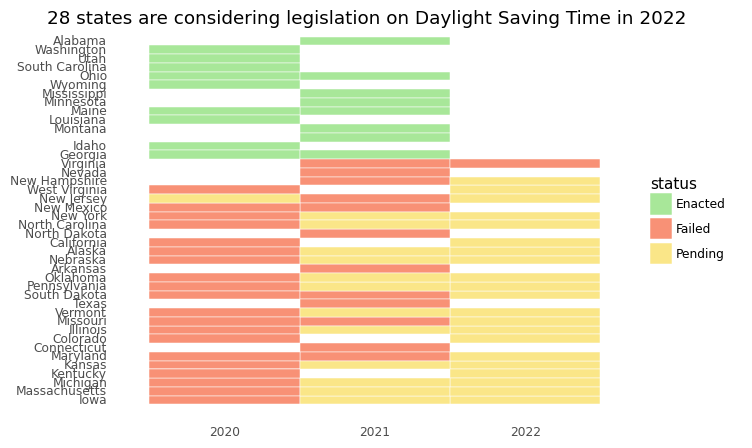

<ggplot: (311431307)>

In [95]:
display(tile_chart)

In [155]:
outcomes_enacted = outcomes[(outcomes.state.isin(list(outcomes[outcomes.status == 'Enacted'].state))) &\
                           (outcomes.year != 2022)]

In [180]:
outcomes_2022_states = list(outcomes[outcomes.year==2022].state.unique())
outcomes_2022 = outcomes[outcomes.state.isin(outcomes_2022_states)]

In [157]:
#Manual sort for chart
enacted_states = pd.DataFrame(
                ['Alabama', 'Georgia', 'Ohio', 'Maine',
                  'Minnesota', 'Mississippi', 'Montana',
                 'Idaho', 'Louisiana', 'South Carolina',
                 'Utah', 'Washington', 'Wyoming'])

In [158]:
enacted_states = enacted_states.reset_index()
enacted_states.columns = ['state_rank', 'state']
outcomes_enacted = outcomes_enacted.merge(enacted_states, on='state')

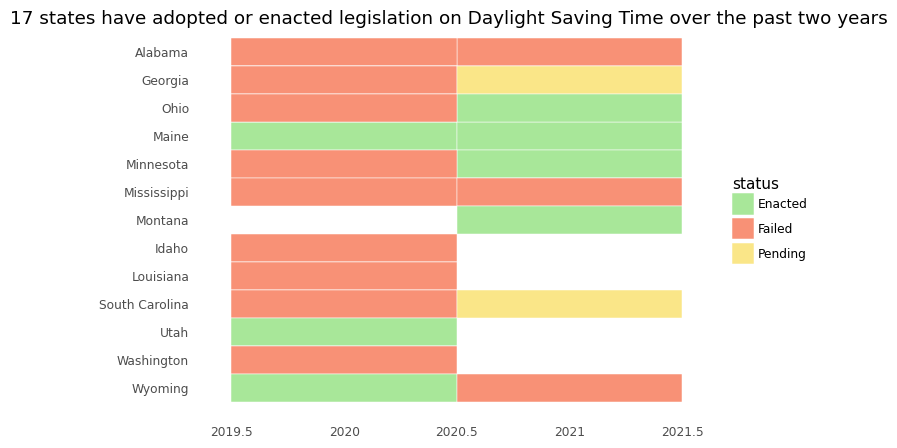

<ggplot: (311679406)>

/Users/jmingram/.pyenv/versions/3.10.0/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/jmingram/.pyenv/versions/3.10.0/lib/python3.10/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: enacted-ugly.svg


In [185]:
order = list(outcomes_enacted.sort_values('state_rank').state.unique())

enacted_chart = (
    ggplot(outcomes_enacted)
    + geom_tile(aes(x='year', y='state', fill='status'), color = "white", size=0.2)
    + scale_fill_manual(['#A8E799', '#F89176', '#FAE688'])
    + theme_minimal()
    + scale_y_discrete(limits=order[::-1])
    + theme(panel_grid_major=element_blank(),
            panel_grid_minor=element_blank())
    + labs(title='17 states have adopted or enacted legislation on Daylight Saving Time over the past two years',
           x='', 
           y='')
)
display(enacted_chart)

enacted_chart.save('enacted-ugly.svg')
#Requires manual cleaning and checking of the colors!

In [181]:
#Manual sorting
pending_states = pd.DataFrame(
                ['Alaska', 'California', 'Iowa', 'Kansas', 'Kentucky', 'Maryland',
                 'Massachusetts', 'Michigan', 'Minnesota', 'Nebraska', 'New Hampshire',
                 'New Jersey', 'North Carolina', 'Ohio', 'South Carolina', 'South Dakota',
                 'Utah', 'Colorado', 'Missouri', 'Vermont', 'Virginia', 'Washington', 
                 'West Virginia', 'Georgia', 'Illinois', 'New York', 'Oklahoma', 
                 'Pennsylvania'])
pending_states = pending_states.reset_index()
pending_states.columns = ['state_rank', 'state']
outcomes_2022 = outcomes_2022.merge(pending_states, on='state')

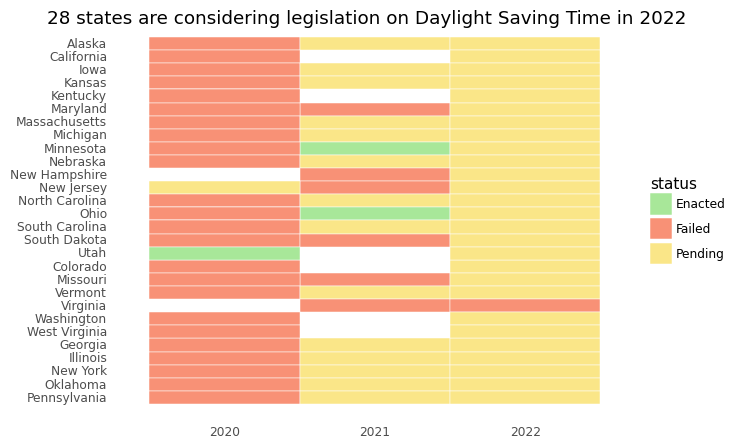

<ggplot: (311042943)>

/Users/jmingram/.pyenv/versions/3.10.0/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/jmingram/.pyenv/versions/3.10.0/lib/python3.10/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: 2022.svg


In [182]:
#order = list(outcomes_2022.sort_values(['status', 'year', 'state'], ascending=[True, False, False]).state.unique())
order = list(outcomes_2022.sort_values('state_rank').state.unique())

chart_2022 = (
    ggplot(outcomes_2022)
    + geom_tile(aes(x='year', y='state', fill='status'), color  = "white", size=0.2)
    + scale_fill_manual(['#A8E799', '#F89176', '#FAE688'])
    + theme_minimal()
    + scale_y_discrete(limits=order[::-1])
    + theme(panel_grid_major=element_blank(),
            panel_grid_minor=element_blank())
    + labs(title='28 states are considering legislation on Daylight Saving Time in 2022',
           x='', 
           y='')
)
display(chart_2022)

chart_2022.save('2022.svg')